In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import pickle
from matplotlib import animation

# cells defined in earlier notebooks

In [2]:
def saddle_node_locator(ss_list):
    """
    find point where steady state (ss) jumps (hysteresis)
    where unsteady state manifold appears/disappears
    """
    for n,(i,j) in enumerate(zip(ss_list[:-1], ss_list[1:])):
        if abs(j-i) > 0.3:
            return n+1

In [3]:
def R_pheno(A,t):
    """
    system of ODEs simplifying the Zaytsev 2016 model, using:
    - Michaelis constants (Kr, Kr) to describe both binding + product formation
    - Hill coefficients (n, m) to describe nonlinear activity
    """
    phos = cis + trans*A**n/(Kf**n + A**n)
    dephos = inact*P*Kr**m/(Kr**m + A**m)
    return phos*(Atot - A) - dephos*A

In [4]:
def mesh_fourier(zmin,zmax,nz):
    """
    discrete approximation of the spatial derivative operator (Laplacian)
    uses spectral symmetry to simplify operations, forces periodic boundary conditions
    """
    dz = np.zeros((nz,nz))
    for i in range(nz):
        for j in range(nz):
            if i == j:
                dz[i,i] = 0
            else:
                dz[i,j] = np.pi*(-1)**((i-1)+(j-1))/(zmax-zmin)/np.tan(((i-1)-(j-1))*np.pi/(nz))
    return dz

In [5]:
def find_nearest(array, value):
    """
    returns location of point nearest to input value within input array
    """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

In [6]:
def spatial_simulation_nonbind_pheno(Atot,lo_ss,t_end,dt,t_save,L,N):
    """
    reaction-diffusion algorithm using the phenomenological model, defined in 4.3.
    initial active kinase is situated in a Gaussian-like distribution
    phosphatase is a fixed constant across domain
    """
    
    A = np.ones(N)*lo_ss
    
    y = A,Atot
    
    A_arr = np.zeros((N,round(t_end/t_save)+1))
    t_vec = np.zeros(round(t_end/t_save)+1)
    
    A_arr[:,0] = A
    
    dz = mesh_fourier(0,L,N)
    dz2 = np.dot(dz,dz)
    
    counter = 0
    counter_save = 0
    t = 0
    
    for i in range(round(t_end/dt)+1):
        counter += 1
        
        A += dt*(R_pheno(A,t) + D*np.dot(dz2,A))
        t += dt
        
        y = A,Atot
        
        if counter == round(t_save/dt):
            counter = 0
            counter_save += 1
            
            A_arr[:,counter_save] = A
            t_vec[counter_save] = t
        
        arrays = A_arr,t_vec
    return arrays, A

In [7]:
"""
parameters for the phenomenological model chosen for conceptual simplicity
"""

cis   = .01   # to reflect large difference between 'in cis' & 'in trans' reaction rates
trans = 1
inact = 1
Kf    = 1
Kr    = 1
n = 2         # Hill coefficient > 1 to reflect nonlinear activation
m = 1         # Hill coefficient = 1 to reflect linear inactivation

# geometric analysis & the maxwell point in the phenomenological model

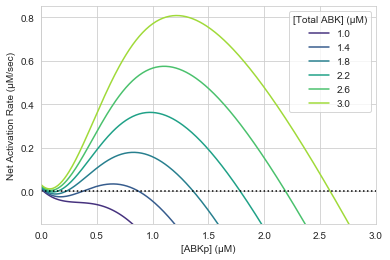

In [8]:
"""
Figure 18A
calculates/plots net activation rate (dA/dt) for 0.5 uM phosphatase + varying total kinase

- monostable behavior results from a net activation curve crossing the x-axis once
    - intersection determines steady state
        - high intersection : autoactivation
        - low intersection : inactivation
- triply intersecting net activation curves reflect bistability
    - 1st/3rd intersections are the low/high steady states, respectively
    - 2nd intersection reflects the bistable threshold
    - areas between the curve/x-axis to the left/right of this threshold determine front direction
        - the greater area pulls a traveling front towards activation/inactivation
        - equal areas result in a stationary (pinned) front at the maxwell point

- 1.0 uM total ABK : monostable low, inactivation dominates
- 1.4 uM total ABK : bistable, above = below area, front will be stationary (pinned)
- 1.8-2.6 uM total ABK : bistable, above > below area, outwardly propagating traveling front
- 3.0 uM total ABK : monostable high, autoactivation dominates
"""

t = 0
P = 0.5
Atot_range = np.arange(1,3.1,.4)

colors = sns.color_palette('viridis', n_colors=len(Atot_range))
for i,Atot in enumerate(Atot_range):
    A = np.arange(0,Atot+.1,.01)
    plt.plot(A,R_pheno(A,t), color=colors[i], label=f'{round(Atot,2)}')

plt.axhline(0,color='k',linestyle=':')
plt.ylim(-.15,.85)
plt.xlim(0,3)
plt.legend(title='[Total ABK] (\u03BCM)')
plt.ylabel('Net Activation Rate (\u03BCM/sec)')
plt.xlabel('[ABKp] (\u03BCM)');

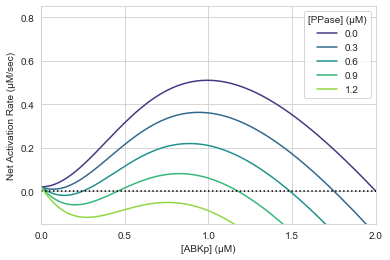

In [9]:
"""
Figure 18B
calculates/plots net activation rate (dA/dt) for 2 uM total kinase + varying phosphatase

- 0-0.3 uM PPase : monostable high, activation dominates
- 0.6 uM PPase : bistable, above > below area, outwardly propagating traveling front
- 0.9 uM PPase : bistable, above = below area, front will be stationary (pinned)
- 1.2 uM PPase : monostable low, inactivation dominates
"""

t = 0
Atot = 2
P_range = np.arange(0,1.3,.3)

colors = sns.color_palette('viridis', n_colors=len(P_range))
for i,P in enumerate(P_range):
    plt.plot(A,R_pheno(A,t), color=colors[i], label=f'{round(P,1)}')

plt.axhline(0,color='k',linestyle=':')
plt.ylim(-.15,.85)
plt.xlim(0,2)
plt.locator_params(axis='x', nbins=5)
plt.legend(title='[PPase] (\u03BCM)')
plt.ylabel('Net Activation Rate (\u03BCM/sec)')
plt.xlabel('[ABKp] (\u03BCM)');

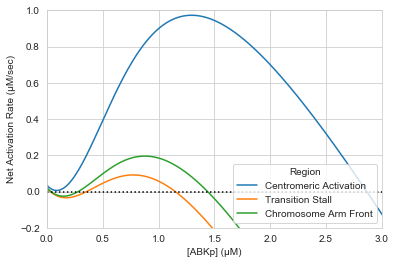

In [10]:
"""
Figure 19A
calculates/plots net activation rate (dA/dt) for .65 uM phosphatase + specific total kinase
concentrations/colors chosen relate to the different behavioral regions of Figure 17 A/C/D

- autoactivation region : monostable high
- chromosome arm front : bistable, above > below area, traveling front propagates outward
- transition stall : bistable, above slightly greater than below, slow outward propagation
"""

t = 0
P = 0.65
Atot_range = [3.4,1.75,2]
colors = ['C00','C01','C02']
labels = ['Centromeric Activation','Transition Stall', 'Chromosome Arm Front']

for i,(Atot,color,label) in enumerate(zip(Atot_range,colors,labels)):
    A = np.arange(0,Atot+.1,.01)
    plt.plot(A,R_pheno(A,t), color=color, label=label)
    
plt.axhline(0,color='k',linestyle=':')
plt.ylim(-.2,1)
plt.xlim(0,3)
plt.locator_params(axis='x', nbins=8)
plt.legend(title='Region',loc='lower right')
plt.ylabel('Net Activation Rate (\u03BCM/sec)')
plt.xlabel('[ABKp] (\u03BCM)');

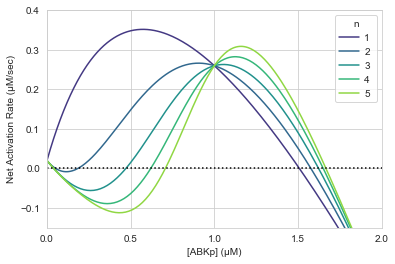

In [11]:
"""
Figure 19B
calculates/plots net activation rate (dA/dt) for 2 uM total kinase + 0.5 uM phosphatase +
varying Hill coefficient 'n'

- n = 1 : curve becomes parabolic, bistability vanishes (only 1 x-axis intersections possible)
- n > 1 : increase in nonlinearity (cooperativity) increases bistability strength, shown by 
the deepening areas above/below the x-axis
"""

t = 0
Atot = 2
P = 0.5

Kf = 1
cis = 0.01

n_range = np.arange(1,5.1,1)

colors = sns.color_palette('viridis', n_colors=len(n_range))
for i,n in enumerate(n_range):
    A = np.arange(0,Atot+.1,.01)
    plt.plot(A,R_pheno(A,t), color=colors[i], label=f'{int(n)}')

plt.axhline(0,color='k',linestyle=':')
plt.ylim(-.15,.4)
plt.xlim(0,2)
plt.locator_params(axis='x', nbins=5)
plt.ylabel('Net Activation Rate (\u03BCM/sec)')
plt.xlabel('[ABKp] (\u03BCM)')

legend = plt.legend(title='n')
# aligns legend labels, since they are unaligned without this command
for t in legend.get_texts():
    t.set_ha('center')

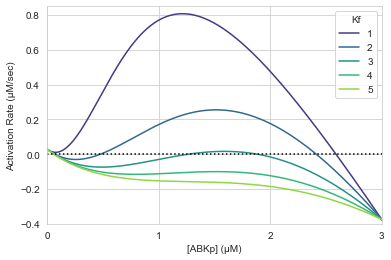

In [12]:
"""
Figure 19B
calculates/plots net activation rate (dA/dt) for 2 uM total kinase + 0.5 uM phosphatase +
varying Michaelis constant 'Kf'

- high Kf : bistability vanishes
    - shows need for stable 'in trans' complexing of inactive/active kinase
"""

t = 0
Atot = 3
P = 0.5

n = 2
cis = 0.01

Kf_range = [1,2,3,4,5]

colors = sns.color_palette('viridis', n_colors=len(Kf_range))
for i,Kf in enumerate(Kf_range):
    A = np.arange(0,Atot+.1,.01)
    plt.plot(A,R_pheno(A,t), color=colors[i], label=f'{Kf}')
    
plt.axhline(0,color='k',linestyle=':')
plt.ylim(-.4,.85)
plt.xlim(0,3)
plt.locator_params(axis='x', nbins=5)
plt.legend(title='Kf')
plt.ylabel('Activation Rate (\u03BCM/sec)')
plt.xlabel('[ABKp] (\u03BCM)');

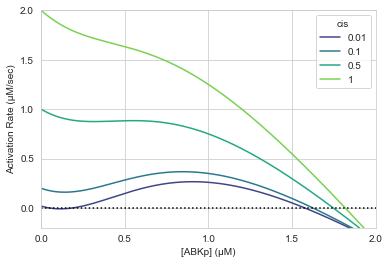

In [13]:
"""
Figure 19B
calculates/plots net activation rate (dA/dt) for 2 uM total kinase + 0.5 uM phosphatase +
varying in cis autoactivation parameter 'cis'

- high 'cis' : bistability vanishes
    - reduces effective nonlinearity of the 'in trans' pathway relative to the 'in cis' pathway
"""

t = 0
Atot = 2
P = 0.5

n = 2
Kf = 1

cis_range = [0.01,.1,.5,1]

colors = sns.color_palette('viridis', n_colors=len(cis_range))
for i,cis in enumerate(cis_range):
    A = np.arange(0,Atot+.1,.01)
    plt.plot(A,R_pheno(A,t), color=colors[i], label=f'{cis}')

plt.axhline(0,color='k',linestyle=':')
plt.ylim(-.2,2)
plt.xlim(0,2)
plt.locator_params(nbins=5)
plt.legend(title='cis')
plt.ylabel('Activation Rate (\u03BCM/sec)')
plt.xlabel('[ABKp] (\u03BCM)');

# pinned front at the maxwell point

In [14]:
"""
resets parameters varied in the above figures
calculates low steady state of active kinase for following spatial simulation
"""

t = 0
Atot = 2
P = 0.5

n = 2
Kf = 1
cis = 0.01

A = odeint(R_pheno,0,np.linspace(0,100*60,1000))
lo_ss = A[-1][0]

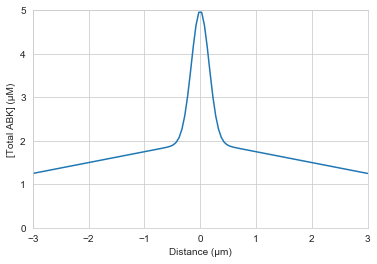

In [15]:
"""
constructs total kinase profile with:
- Gaussian-like centromeric spike
- ramps decreasing in total kinase along outer chromosome arms
    - gradually decreasing total kinase is to demonstrate a traveling front slowing/stopping (pinning)
"""

L = 6
N = 120
x = np.linspace(-L/2,L/2,N)

Atot_b = 2
Atot_h = 1.5
Atot_w = 10
Aramp_slope = .25
Aramp = abs(Aramp_slope*x)
Atot = Atot_b*Atot_h * np.exp(- Atot_b*Atot_w * x**2) + Atot_b - Aramp

plt.plot(x,Atot)
plt.ylim(0,5)
plt.ylabel('[Total ABK] (\u03BCM)')
plt.xlim(-3,3)
plt.xlabel('Distance (\u03BCm)');

In [16]:
"""
simulates/plots results using the above total kinase profile
"""

t_end = 300
dt = 0.01
t_save = .1

n = 2
Kf = 1
cis = 0.01

D = 0.001

(A_arr,t_vec),A = spatial_simulation_nonbind_pheno(Atot,lo_ss,t_end,dt,t_save,L,N)

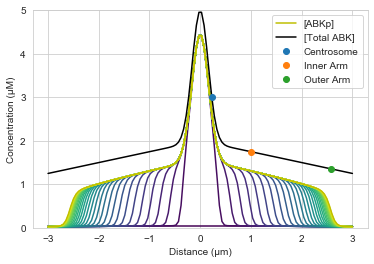

In [17]:
"""
Figure 20A
plots simulation results along with the total kinase profile
- front slows along the ramp + pins in the outer arm at the maxwell point (green)
"""

colors = sns.color_palette('viridis', n_colors=len(t_vec))
for i in range(0,len(t_vec)-1,100): ## line every 10 sec
    plt.plot(x,A_arr[:,i], color=colors[i])
plt.plot(x,A_arr[:,-1],'y',label='[ABKp]')

plt.plot(x,Atot,'k',label='[Total ABK]')
plt.plot(.23,3,'C0o',label='Centrosome')
plt.plot(1,1.75,'C1o',label='Inner Arm')
plt.plot(2.58,1.35,'C2o',label='Outer Arm')
plt.legend()

plt.ylabel('Concentration (\u03BCM)')
plt.xlabel('Distance (\u03BCm)')
plt.ylim(0,5)
plt.locator_params(axis='y', nbins=5);

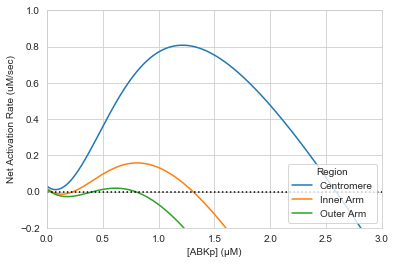

In [18]:
"""
Figure 20B
calculates/plots net activation rate (dA/dt) for .5 uM phosphatase + specific total kinase
concentrations relating to the different behavioral regions of Figure 20A

- the green curve shows equal areas above/below the x-axis, proving that geometric analysis
can be used to predict the maxwell point where a traveling front pins
"""

t = 0
P = 0.5
Atot_range = [3,1.75,1.35]
colors = ['C00','C01','C02']
labels = ['Centromere','Inner Arm', 'Outer Arm']

for i,(Atot,color,label) in enumerate(zip(Atot_range,colors,labels)):
    A = np.arange(0,Atot+.1,.01)
    plt.plot(A,R_pheno(A,t), color=color, label=label)
    
plt.axhline(0,color='k',linestyle=':')
plt.ylim(-.2,1)
plt.xlim(0,3)
plt.locator_params(axis='x', nbins=8)
plt.legend(title='Region',loc='lower right')
plt.ylabel('Net Activation Rate (uM/sec)')
plt.xlabel('[ABKp] (\u03BCM)');